# Bayesian Analysis of Clinical Scenario in "Don't Drop The Anchor" by Manesh, R.S., et. al. (2014)

### Introduction

In this notebook, we will run through how to apply bayes law in the clinical scenario presented by *Manesh et.al* in their article titled *Don't Drop The Anchor.* The manuscript opens with this clinical vignette:

```
A 67-year-old man with painless jaundice for 3 weeks was brought to the emergency department by his brother. The patient noted yellow eyes and skin, white stool, fatigue, and pruritis that interfered with sleep. He denied abdominal pain, fevers, chills, diarrhea, melena, hematochezia, anorexia, dysphagia, nausea, or vomiting. He had noted a 20-lb unintentional weight loss over the last 2 months. His past medical history was notable for a stab wound in his abdomen for which he had undergone laparotomy without bowel resection many years ago. He took no medications. He was a Japanese-American Vietnam War veteran who lived with his ex-wife and owned a video store. He had previously drunk 12 beers daily, but cut back to 2 daily 1 year ago. He had a 50 pack-year smoking history and denied any illicit drug use. His family history was negative for malignancy or liver disease.
```

In the work-up of the patient, malignancy is one of the leading diagnoses given the clinical presentation in the setting of a relevant social history. A CT Abdomen is ordered which demonstrates marked intrahepatic and extrahepatic biliary dilation with abrupt tapering of the common bile duct (CBD) in the region of the pancreatic head. However, no pancreatic mass can be appreciated on the imaging.

Given these findings, the work-up continues with n endoscopic ultrasound (EUS) with fine-needle aspiration (FNA) that demonstrates a 2.3 × 2.8-cm mass in the uncinate process of the pancreas without vascular invasion. While a mass was not originally appreciated on the initial imaging, these findings are highly concerning for cancer of the pancreatic head, and at this time, the clinicians begin considering the need for a Whipple procedure confirm the diagnosis and provide definitive and possibly life-saving treatment. At this point, the authors conclude that with this evidence thus far, the pre-test probability of this presentation being pancreatic cancer is 90%.

However, the authors order two more tests to help confirm their diagnosis before proceeding to an invasive and possibly morbid Whipple procedure (A Whipple procedure entails at least a 3% operative mortality, prolonged postoperative recovery, and the need for lifelong pancreatic enzyme replacement therapy). To do so, two tests are ordered. 1) CA-19-9 level which is a tumor marker that can be measured in the blood and 2) Fine Needle Aspiration (FNA) to biopsy the lesion and look at the tissue for diagnosis. While no test is perfect, these steps in the diagnostic pipeline are leveraged by the clinical team to provide further confirmation before exposing this patient to the risk of a Whipple procedure.


### Applying Bayes Law

In the article, the authors walk through how they would apply Bayes law (formulated to use likelihood ratios - LR) to take their prior clinical belief of 0.90 and update it with evidence from the CA-19-9 and FNA biopsy. Below, we will replicate those results in code.

First, we will bring in some python imports.

In [3]:
import pymc3 as pm
import arviz as az
import numpy as np

We will then declare variables to represent the prior belief (**prior_p**), the prior odds (**prior_odds**), and the negative likelihood ratio (LR) for the CA-19-9 test (**lr_ca19_9**).

In [13]:
prior_p = 0.90
prior_odds = prior_p/(1-prior_p)
lr_ca19_9 = 0.25
print('Prior Belief = '+ str(prior_p))

Prior Belief = 0.9


We will then apply Bayes rule (adopted for use with LR) to compute the post CA-19-9 odds and probability.

In [14]:
post_ca19_9_odds = prior_odds*lr_ca19_9
post_ca19_9_p = post_ca19_9_odds/(post_ca19_9_odds+1)
print('Post CA-19-9 = ' + str(post_ca19_9_p))

Post CA-19-9 = 0.6923076923076924


Finally, we will apply Bayes rule one more time to come to the final posterior probability after we have received the results from both the CA-19-9 and FNA biopsy.

In [15]:
lr_fna = 0.11
post_fna_odds = post_ca19_9_odds*lr_fna
post_fna_p = post_fna_odds/(post_fna_odds+1)
print('Post FNA = ' + str(post_fna_p))

Post FNA = 0.19839679358717438


### A Full Bayesian Approach

One particular short-coming of doing an analysis above is our calculations do not give us any appreciation for the certainty of our results. We do not know whether the final probability of 0.20 is 

In [4]:
def run_model():
    likelihood_ca19_9 = 0.25
    likelihood_fna = 0.11
    certainty = 1
    alpha = 9 * certainty
    beta = 1 * certainty
    mean_prior = alpha / (alpha + beta)
    var_prior = (alpha * beta) / (np.power(alpha + beta, 2) * (alpha + beta + 1))

    with pm.Model() as model:
        #pre_test prob 1
        "assuming beta prior with a mean of 0.90"
        p_1 = pm.Beta('p_1',alpha=alpha,beta=beta)

        "assuming uninformed prior belief"
        #p_1 = pm.Uniform('p_1')

        o_1 = pm.Deterministic('o_1',(p_1/(1-p_1)))
        sens_ca19_9 = pm.Uniform('sens_ca19_9',lower=0.70,upper=0.92)
        l_ca19_9 = pm.Deterministic('l_ca19_9',(1-sens_ca19_9)/sens_ca19_9)

        #prob after CA-19-9
        o_2 = pm.Deterministic('o_2',o_1*l_ca19_9)
        p_2 = pm.Deterministic('p_2',o_2/(o_2+1))

        #prob after FNA
        l_fna = likelihood_fna
        o_3 = pm.Deterministic('o_3',o_2*l_fna)
        p_3 = pm.Deterministic('p_3',o_3/(o_3+1))

        model_trace = pm.sample(cores=1,chains=1,draws=10000)
        return model_trace

In [5]:
model_trace = run_model()

/Users/johnwilliam/Dropbox/TPG/reza_analysis/venv/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sens_ca19_9, p_1]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


/Users/johnwilliam/Dropbox/TPG/reza_analysis/venv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/johnwilliam/Dropbox/TPG/reza_analysis/venv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'p_1'}>,
        <AxesSubplot:title={'center':'p_1'}>],
       [<AxesSubplot:title={'center':'p_2'}>,
        <AxesSubplot:title={'center':'p_2'}>],
       [<AxesSubplot:title={'center':'p_3'}>,
        <AxesSubplot:title={'center':'p_3'}>]], dtype=object)

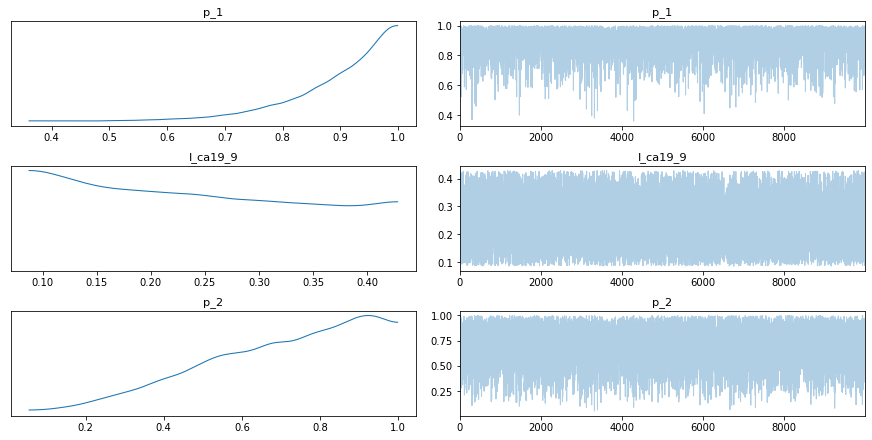

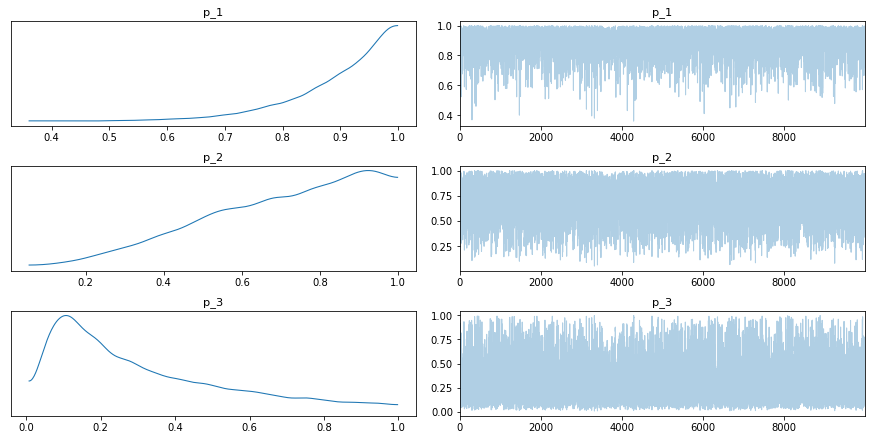

In [6]:
az.plot_trace(model_trace,var_names=['p_1','l_ca19_9','p_2'])
az.plot_trace(model_trace,var_names=['p_1','p_2','p_3'])